In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = 'drive/My Drive/11dacon/'

In [0]:
import pandas as pd
import numpy as np
import datetime
import os
import gc

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
os.listdir(path)

['[11th] 데이터 설명_1002수정.docx',
 'test.csv',
 'train.csv',
 'submission.csv',
 '.ipynb_checkpoints',
 'Starter code.ipynb']

In [0]:
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
sub = pd.read_csv(path+'submission.csv')

In [0]:
train.drop(columns=train.columns[train.isna().sum() == 16909], inplace=True)

##### data fillna
https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html

# Data Check

In [0]:
train.shape, test.shape, sub.shape

((16909, 1301), (8760, 201), (200, 40))

In [0]:
train.head()

,Time,X692,X1272,X553,X1299,X4,X598,X1003,X1010,X1216,X1047,X381,X466,X1420,X686,X711,X1251,X828,X1350,X1066,X1293,X1148,X451,X174,X74,X626,X1083,X1000,X632,X1380,X607,X680,X977,X492,X968,X891,X122,X489,X86,X392,...,X109,X224,X1259,X1143,X1324,X889,X689,X447,X1270,X827,X1037,X942,X1498,X678,X1100,X239,X1369,X436,X536,X933,X1035,X1194,X1441,X291,X1328,X1323,X616,X1195,X944,X1017,X1164,X656,X1287,X324,X767,X1271,X1288,X58,X1033,X1163
0,2016-07-26 11:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-07-26 12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-07-26 13:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-07-26 14:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-26 15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
test.head()

,Time,X26,X303,X241,X435,X402,X352,X305,X350,X326,X299,X160,X125,X211,X349,X407,X330,X132,X231,X225,X16,X286,X354,X353,X76,X255,X106,X393,X157,X323,X130,X269,X94,X172,X289,X216,X123,X398,X233,X214,...,X377,X232,X333,X140,X44,X37,X42,X422,X50,X386,X80,X250,X142,X235,X446,X331,X102,X186,X243,X194,X183,X139,X459,X457,X70,X368,X282,X426,X47,X192,X283,X329,X223,X266,X20,X443,X347,X75,X107,X230
0,2017.7.1 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.273,NaN,0.385,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.305,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.860,NaN,NaN,NaN,NaN,NaN,0.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.275,0.021,NaN
1,2017.7.1 1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166,NaN,0.401,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.308,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.792,NaN,NaN,NaN,NaN,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.222,0.021,NaN
2,2017.7.1 2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164,NaN,0.409,NaN,NaN,NaN,NaN,NaN,0.092,NaN,NaN,NaN,0.344,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.837,NaN,NaN,NaN,NaN,NaN,0.483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.237,0.021,NaN
3,2017.7.1 3:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.168,NaN,0.431,NaN,NaN,NaN,NaN,NaN,0.092,NaN,NaN,NaN,0.312,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.245,NaN,NaN,NaN,NaN,NaN,0.501,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.229,0.020,NaN
4,2017.7.1 4:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.196,NaN,0.353,NaN,NaN,NaN,NaN,NaN,0.093,NaN,NaN,NaN,0.306,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.813,NaN,NaN,NaN,NaN,NaN,0.448,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.202,0.021,NaN


In [0]:
sub.head()

,meter_id,X2018_7_1_1h,X2018_7_1_2h,X2018_7_1_3h,X2018_7_1_4h,X2018_7_1_5h,X2018_7_1_6h,X2018_7_1_7h,X2018_7_1_8h,X2018_7_1_9h,X2018_7_1_10h,X2018_7_1_11h,X2018_7_1_12h,X2018_7_1_13h,X2018_7_1_14h,X2018_7_1_15h,X2018_7_1_16h,X2018_7_1_17h,X2018_7_1_18h,X2018_7_1_19h,X2018_7_1_20h,X2018_7_1_21h,X2018_7_1_22h,X2018_7_1_23h,X2018_7_1_24h,X2018_7_1_d,X2018_7_2_d,X2018_7_3_d,X2018_7_4_d,X2018_7_5_d,X2018_7_6_d,X2018_7_7_d,X2018_7_8_d,X2018_7_9_d,X2018_7_10_d,X2018_7_m,X2018_8_m,X2018_9_m,X2018_10_m,X2018_11_m
0,X5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,X7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,X10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,X16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,X18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA

In [0]:
def plot_show(column, train=True):
    plt.figure(figsize=(15, 4))
    if train:
        sns.scatterplot(x=train[column].index, y=train[column].fillna(0))
        plt.show()
    else:
        sns.scatterplot(x=test[column].index, y=test[column].fillna(0))
        plt.show()

In [0]:
features = train.columns
features = features[features!='Time']

features = ['X000' + i.split('X')[1] if len(i)==2 else i for i in features]
features = ['X00' + i.split('X')[1] if len(i)==3 else i for i in features]
features = ['X0' + i.split('X')[1] if len(i)==4 else i for i in features]

features2 = ['Time']
features2 += features
train.columns = features2

features = sorted(features)

In [0]:
for column in features:
    plot_show(column)

In [0]:
features = test.columns
features = features[features!='Time']

features = ['X00' + i.split('X')[1] if len(i)==2 else i for i in features]
features = ['X0' + i.split('X')[1] if len(i)==3 else i for i in features]

features2 = ['Time']
features2 += features
test.columns = features2

features = sorted(features)

In [0]:
for column in features:
    plot_show(column, train=False)

# Modeling

In [0]:
from numba import jit
import math

@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

In [0]:
train_true = np.concatenate(train.iloc[:, 1:].fillna(0).values)
smape_fast(train_true, train_true)

0.0

In [0]:
train['Time'] = pd.to_datetime(train['Time'])
test['Time'] = pd.to_datetime(test['Time'])

In [0]:
train.set_index('Time', inplace=True)

In [0]:
# interploate 보간법
# df.interpolate(method='spline', order=2)
# df.interpolate(method='polynomial', order=2)
# methods = ['linear', 'quadratic', 'cubic']

# ser.interpolate(limit=1, limit_direction='backward')
# ser.interpolate(limit=1, limit_direction='both')
interpolate_train = train.interpolate(limit_direction='both')
interpolate_test = test.interpolate(limit_direction='both')

In [0]:
import statsmodels.api as sm

In [0]:
X26 = interpolate_test.loc[interpolate_test['X26'].diff().replace(0, np.nan).dropna().index, 'X26']
df = pd.DataFrame(X26.reset_index(drop=True))

# Applying Seasonal ARIMA model to forcast the data 
mod = sm.tsa.SARIMAX(X26, trend='n', order=(1,2,1), seasonal_order=(1,1,1,6))
results = mod.fit()
print(results.summary())

df['forecast'] = results.predict(start = len(X26)-800, end= len(X26), dynamic= True)  
df[['X26', 'forecast']].plot(figsize=(15, 4))
plt.show()

# Model2

In [0]:
test['Time'] = pd.to_datetime(test['Time'])

In [0]:
from sklearn.metrics import mean_absolute_error
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend", linewidth=.5)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
    
    plt.plot(series[window:], label="Actual values", linewidth=.5)
    plt.legend(loc="upper left")
    plt.grid(True)

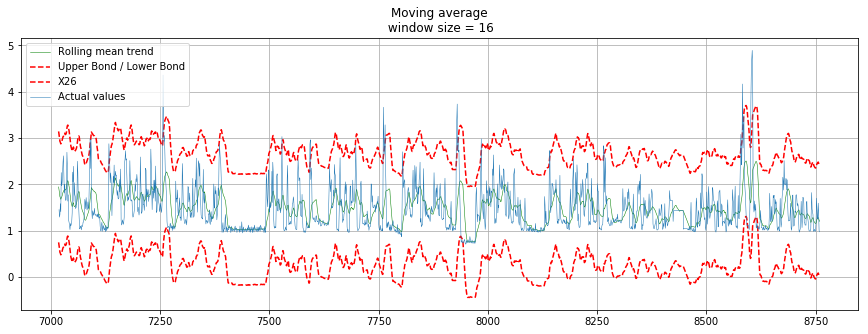

In [27]:
# MA 방법, 이동평균 방법은 anomaly에 취약하다. 이상치에 때문에 값이 튄다.

plotMovingAverage(test['X26'].dropna(), 16, plot_intervals=True)

In [0]:
# weight average, 그래서 weight를 준 MA모형을 생각해 본다.

In [0]:
# 지수 평활법, Exponential smoothing -> 현재시점에서 멀어질수록 낮은 가중치를 가하는 것이 특징

In [0]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);

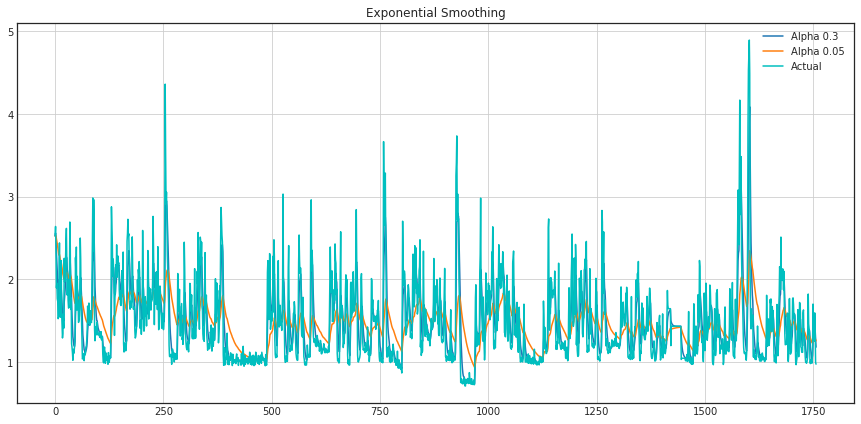

In [33]:
plotExponentialSmoothing(test['X26'].dropna().reset_index(drop=True), [0.3, 0.05])

In [0]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)

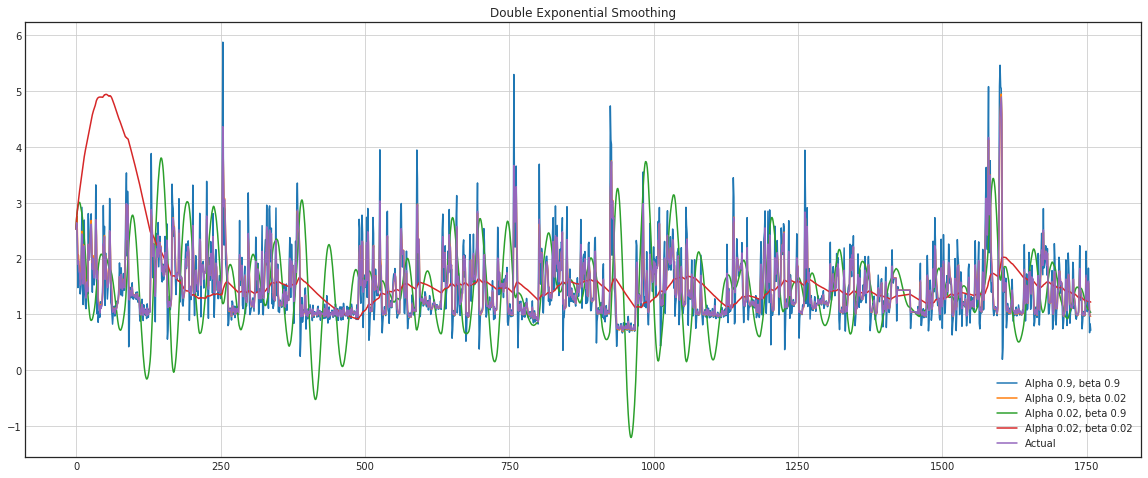

In [35]:
plotDoubleExponentialSmoothing(test['X26'].dropna().reset_index(drop=True), alphas=[0.9, 0.02], betas=[0.9, 0.02])

#### time series
https://www.kaggle.com/hsankesara/time-series-analysis-and-forecasting-using-arima

https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python